In [1]:
import copy
import numpy as np
import mgym
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
EPISODES = 2500

In [3]:
class DeepSARSAgent:
    def __init__(self, env):
        self.env = env
        
        self.state_size = 4
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        
        self.epsilon = 1.
        self.epsilon_decay = 0.9999
        self.epsilon_min = 0.01
        self.model = self._build_model()
        
    def _build_model(self):
        model = Sequential()
        model.add(Dense(30, input_dim=self.state_size, activation='relu'))
        model.add(Dense(30, activation='relu'))
        model.add(Dense(self.env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model
    
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            state = np.float32(state)
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])
        
    def train_model(self, state, action, reward, next_state, next_action, done):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        state = np.float32(state)
        next_state = np.float32(next_state)
        target = self.model.predict(state)[0]
        
        if done:
            target[action] = reward
        else:
            target[action] = (reward + self.discount_factor * self.model.predict(next_state)[0][next_action])
            
        target = np.reshape(target, [1, -1])
        
        self.model.fit(state, target, epochs=1, verbose=0)

In [4]:
env = mgym.make("5x5moving")

In [5]:
agent = DeepSARSAgent(env)

In [6]:
scores, episodes = [], []

for e in range(EPISODES):
    if e % 100 == 0:
        print(e)
        
    done = False
    score = 0
    state = env.reset()
    state = np.reshape(state, [1, -1])
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, -1])
        next_action = agent.get_action(next_state)
        
        agent.train_model(state, action, reward, next_state, next_action, done)
        
        state = next_state
        score += reward
        state = copy.deepcopy(next_state)
        
        if done:
            scores.append(score)
            episodes.append(e)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


In [7]:
import matplotlib.pyplot as plt

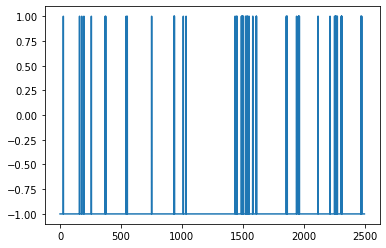

In [9]:
plt.plot(scores)